In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

✅ Model loaded successfully.

🔍 True cls=1, Pred cls=1
    True fat=40.0%, Pred fat=41.1%


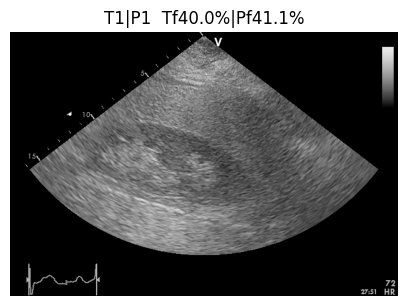

In [65]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as sio
from PIL import Image
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import transforms

# ---------------------------
# Device setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Model Definition
# ---------------------------
class HybridNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.cls_head = nn.Sequential(
            nn.Linear(in_f, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        self.reg_head = nn.Sequential(
            nn.Linear(in_f, 256), nn.SiLU(), nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        return self.cls_head(feats), self.reg_head(feats).squeeze(1)

# ---------------------------
# Inference Function
# ---------------------------
def inference(volume_3d, true_lbl, true_fat, model, scaler, transform):
    model.eval()
    sl = volume_3d.shape[0] // 2
    arr = volume_3d[sl].astype(np.float32)
    arr = (arr - arr.min()) / (arr.ptp() + 1e-8) * 255
    img = Image.fromarray(arr.astype(np.uint8), 'L')
    inp = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, pred_s = model(inp)
    pred_cls = logits.argmax(1).item()
    pred_f = scaler.inverse_transform([[pred_s.item()]])[0][0]
    print(f"\n🔍 True cls={true_lbl}, Pred cls={pred_cls}")
    print(f"    True fat={true_fat:.1f}%, Pred fat={pred_f:.1f}%")
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"T{true_lbl}|P{pred_cls}  Tf{true_fat:.1f}%|Pf{pred_f:.1f}%")
    plt.show()
    return true_lbl,pred_cls

# ---------------------------
# Load model and weights
# ---------------------------
model = HybridNet().to(device)
model.load_state_dict(torch.load("/kaggle/input/liver_steatosis/pytorch/default/1/model.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully.")

# ---------------------------
# Load dataset (.mat)
# ---------------------------
mat = sio.loadmat("/kaggle/input/dataset-of-bmode-fatty-liver-ultrasound-images/dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")  ]
entries = mat['data'][0]

images, labels, fats = [], [], []
for e in entries:
    images.append(e['images'])                    # (S,H,W)
    labels.append(int(e['class'].squeeze()))
    fats.append(float(e['fat'].squeeze()))
images   = np.stack(images)                         # (N,S,H,W)
labels = np.array(labels, dtype=np.int64)
fats   = np.array(fats, dtype=np.float32)
# ---------------------------
# Build fat % scaler (IMPORTANT!)
# ---------------------------
scaler = StandardScaler()
scaler.fit(fats.reshape(-1, 1))  # Used for inverse_transform during inference

# ---------------------------
# Image preprocessing pipeline
# ---------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.repeat(3,1,1)),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ---------------------------
# Run inference on a patient
# ---------------------------
# 👇 Select any patient index

patient_index = 17
volume_3d = images[patient_index]       # shape: (10,H,W)
true_label = int(labels[patient_index])
true_fat = float(fats[patient_index])
    
true,predicted=inference(volume_3d, true_label, true_fat, model, scaler, transform)

        
